# Data Wrangling
---

>We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.
>
>We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.
>
>One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.
>
>-- The Zillow Data Science Team

---
My first step is going to be to look at the data using Sequel Ace to access the zillow database.

**Takeaways:**

From the `predictions_2017` table:
- The latest transaction date is 2018-05-25
    - This is also the only transaction in the data I'll be looking into that did not occur in 2017
- The earliest transaction date in this data is 2017-01-01

From the `propertylandusetype` table:
- Single Family Residential properties: propertylandusetypeid = 261
- Inferred Single Family Residential properties: propertylandusetypeid = 279
 - There are 0 rows with this land use type, so I won't worry about it or include it in my SQL query
 
From the `properties_2017` table:
- There are a TON of columns in this table
- In the interest of time, I will start by focusing only on these 5 features:
 - bedroomcnt
 - bathroomcnt
 - calculatedfinishedsquarefeet
 - fips
 - taxvaluedollarcnt
- I don't believe fips will have very much of an effect on predicting property tax values but, in the email I received, the team let me know that they would like to know where these properties are located. Therefore, I will include it in my data retrieval so I can also research and deliver that information.
- With more time, I would like to dive into the other columns and implement feature engineering

In [1]:
# import modules
import pandas as pd

In [2]:
# write function to generate url to access SQL server
def get_url(db):
    '''
    This function takes in a database name and returns a url (using the specified 
    database name as well as host, user, and password from env.py) for use in the 
    pandas.read_sql() function.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

I decided to alias most of the columns from the SQL server as I imported them so I can get that out of the way right off the bat. I chose to use more simplified variable names for clarity and ease of use (less typing) in my project. The changes are as follows:
- `bedroomcnt` = `beds`
- `bathroomcnt` = `baths`
- `calculatedfinishedsquarefeet` = `sq_ft`
- `taxvaluedollarcnt` = `tax_value`

In [3]:
# use above function to generate url
url = get_url('zillow')
# write SQL query to retrieve data
sql = "SELECT bedroomcnt as beds, bathroomcnt as baths, calculatedfinishedsquarefeet as sq_ft, taxvaluedollarcnt as tax_value, fips FROM properties_2017 JOIN predictions_2017 USING(parcelid) WHERE transactiondate <= '2017-12-31' AND propertylandusetypeid = 261;"
# assign query result to variable
zillow = pd.read_sql(sql, url)
# preview data
zillow.head()

,beds,baths,sq_ft,tax_value,fips
0,4.0,3.5,3100.0,1023282.0,6059.0
1,2.0,1.0,1465.0,464000.0,6111.0
2,3.0,2.0,1243.0,564778.0,6059.0
3,4.0,3.0,2376.0,145143.0,6037.0
4,4.0,3.0,2962.0,773303.0,6037.0


Before moving forward, I will define a function to acquire the zillow data I will be using and cache it to a .csv file so I won't have to access the SQL server every time I need a fresh copy of the data.

In [4]:
# combine previous steps into function
# add code to cache dataframe to csv file
def acquire_zillow():
    '''
    This function first searches for a .csv file containing the zillow data and then 
    reads that file into a dataframe. If zillow.csv is not found, it uses
    the get_url() helper function to access the SQL server and read the query result 
    into a dataframe. It then caches this data into a csv file (zillow.csv).
    This function takes no arguments and returns a dataframe of zillow data.
    '''
    import os
    if os.path.isfile('zillow.csv'):
        zillow = pd.read_csv('zillow.csv', index_col=0)
        return zillow
    else:
        sql = """
        SELECT bedroomcnt as beds,
        bathroomcnt as baths, 
        calculatedfinishedsquarefeet as sq_ft, 
        taxvaluedollarcnt as tax_value, 
        fips 
        FROM properties_2017 
        JOIN predictions_2017 USING(parcelid) 
        WHERE transactiondate <= '2017-12-31' 
        AND propertylandusetypeid = 261;
        """
        zillow = pd.read_sql(sql, get_url('zillow'))
        zillow.to_csv('zillow.csv')
        return zillow
# test function
zillow = acquire_zillow()
zillow.head()

,beds,baths,sq_ft,tax_value,fips
0,4.0,3.5,3100.0,1023282.0,6059.0
1,2.0,1.0,1465.0,464000.0,6111.0
2,3.0,2.0,1243.0,564778.0,6059.0
3,4.0,3.0,2376.0,145143.0,6037.0
4,4.0,3.0,2962.0,773303.0,6037.0


In [5]:
# view dataframe info
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       52441 non-null  float64
 1   baths      52441 non-null  float64
 2   sq_ft      52359 non-null  float64
 3   tax_value  52440 non-null  float64
 4   fips       52441 non-null  float64
dtypes: float64(5)
memory usage: 2.4 MB


I want to see if any of these columns really need to be floats or if they defaulted to float because of nulls.

In [6]:
# check for null values
zillow.isna().sum()

beds          0
baths         0
sq_ft        82
tax_value     1
fips          0
dtype: int64

In [7]:
# look at value counts for all columns
for col in zillow.columns:
    print(zillow[col].value_counts(dropna=False))
    print()

3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: beds, dtype: int64

2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
8.5         3
11.0        3
18.0        1
13.0        1
Name: baths, dtype: int64

1120.0    128
1200.0    119
1080.0    102
936.0      86
1040.0     86
         ... 
6359.0      1
8161.0      1
5110.0      1
4970.0      1
5479.0      1
Name: sq_ft, Length: 4724, dtype: int64

455000.0    34
600000.0    30
550000.0    24
500000.0    24
450000.0    24
            ..
51101.0      1
82408.0      1
168382.0     1
529723.0     1
409961.0     1
Name: tax_value, Length: 38943, dtype: int64

6037.0    33910
6059.0    14136
6111.

So far, I can see that only `baths` has fractional values, but I want to be sure about the columns that have too many unique values to list: `sq_ft` and `tax_value`.

In [8]:
# crete dataframe of just values after decimal in sq_ft column
sqft_floats = pd.DataFrame([num - int(num) for num in zillow.sq_ft.dropna()], columns=['sqft'])
# view unique values after decimal
sqft_floats.value_counts()

sqft
0.0     52359
dtype: int64

In [9]:
# create dataframe of fractional values in tax_value column
tax_floats = pd.DataFrame([num - int(num) for num in zillow.tax_value.dropna()], columns=['tax'])
# view unique values after decimal
tax_floats.value_counts()

tax
0.0    52440
dtype: int64

In [10]:
# view null tax_value row
zillow[zillow.tax_value.isna()]

,beds,baths,sq_ft,tax_value,fips
42299,4.0,2.0,1197.0,NaN,6059.0


**Takeaways:**
- `fips` is more of a categorical column since it represents a property's location
- `baths` is the only feature with fractional values
 - `beds`, `sq_ft`, `tax_value`, and `fips` could be converted to int dtypes
 - null values would need to be dealt with before converting to int
- There are 82 null values in `sq_ft`
- There is 1 null value in `tax_value`
 - this row has a non-null value for `sq_ft`
- There are a total of 83 rows with null values in this dataset.


In [11]:
f'The proportion of rows with null values in the zillow data is {(83/len(zillow)):%}'

'The proportion of rows with null values in the zillow data is 0.158273%'

Since the proportion of null values in my data is so low, I plan to drop these rows rather than impute data that may not be accurate. With more time, I would like to experiment with imputing data to see if it makes a difference in the model's efficacy.

However, before I drop these rows I want to look for outliers and see if taking care of those outliers helps reduce the number of missing values. I also want to be sure that handling outliers won't make the sample small enough to be more heavily influenced by dropping the rows with null values.

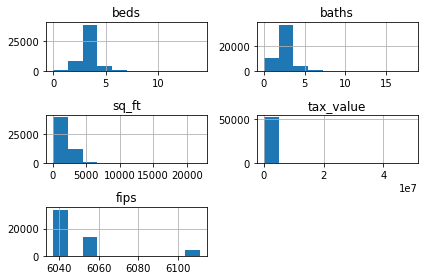

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

# view individual distributions of features
zillow.hist()
plt.tight_layout()

In [13]:
# view descriptive stats (with easy-to-read formatting)
zillow.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,beds,baths,sq_ft,tax_value,fips
count,52441,52441,52359,52440,52441
mean,3.30068,2.2994,1922.89,529688,6049.13
std,0.949094,1.02277,1004.37,751895,21.0291
min,0,0,128,1000,6037
25%,3,2,1268,193748,6037
50%,3,2,1659,373612,6037
75%,4,3,2306,619301,6059
max,14,18,21929,4.90612e+07,6111


<AxesSubplot:>

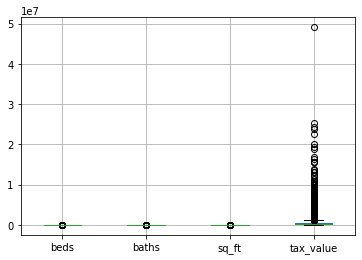

In [14]:
# view boxplots of variables
zillow.drop(columns='fips').boxplot()

Clearly I'll need to scale my data after handling outliers. `tax_value` has such an outlier problem that I can't even see any of the other boxplots if they're all plotted together.

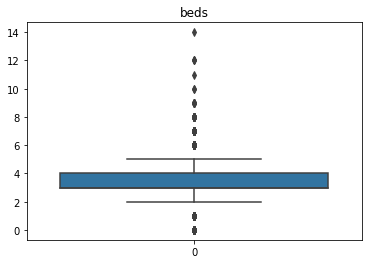

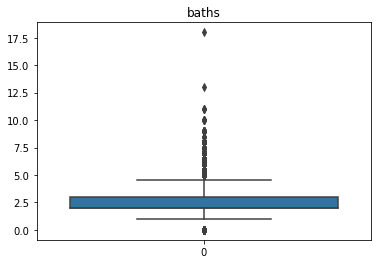

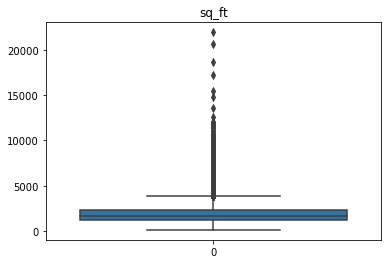

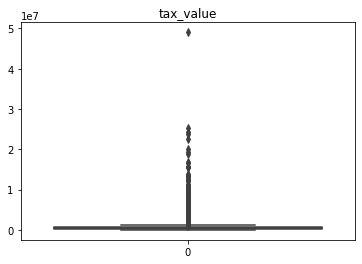

In [15]:
# view individual boxplots for each variable
for col in zillow.drop(columns='fips').columns:
    sns.boxplot(data=zillow[col])
    plt.title(col)
    plt.show()

**Takeaways:**

- Data definitely needs to be scaled after outliers are handled
- There are outliers in every column. 
 - `fips` consists of 3 categorical values so I don't even need to worry about outliers here.
- `tax_value` has the biggest outlier problem
- `beds` and `baths` appear to have mostly normal distributions

I will develop a function to remove outliers. The majority of our target market will most likely be interested in "regular" houses, or those properties whose attributes fall near the median values in this dataset. I don't believe including extravagant properties will be of much benefit to our model since most people aren't interested in those types of properties. If included, they could skew the data and confuse the model, resulting in less accurate predictions of tax assessed value. Therefore, I will remove outliers and focus on properties in the median range.

In [16]:
# create function to remove outliers
def remove_outliers(df, cols, k):
    '''
    This function takes in a list of column names from a dataframe and a 
    k-value (int) which is used to specify the upper and lower bounds for
    removing outliers. It returns the dataframe with the outliers removed.
    '''
    # make for loop to remove outliers in each column
    for col in cols:
        # get quartiles
        q1, q3 = df[col].quantile([.25, .75])
        # compute iqr
        iqr = q3 - q1
        # get cutoff points for removing outliers
        upper = q3 + k * iqr
        lower = q1 - k * iqr
        # remove outliers
        df = df[(df[col]>lower)&(df[col]<upper)]
    return df

In [17]:
# remove outliers from all columns but fips, k=1.5
no_outliers = remove_outliers(zillow, ['beds', 'baths', 'sq_ft', 'tax_value'], 1.5)
# view info without outliers
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45626 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       45626 non-null  float64
 1   baths      45626 non-null  float64
 2   sq_ft      45626 non-null  float64
 3   tax_value  45626 non-null  float64
 4   fips       45626 non-null  float64
dtypes: float64(5)
memory usage: 2.1 MB


In [18]:
# re-view info with outliers
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       52441 non-null  float64
 1   baths      52441 non-null  float64
 2   sq_ft      52359 non-null  float64
 3   tax_value  52440 non-null  float64
 4   fips       52441 non-null  float64
dtypes: float64(5)
memory usage: 4.4 MB


In [19]:
# calculate data lost/retained
print(f'Number of rows dropped: {len(zillow) - len(no_outliers)}')
print(f'Proportion of outliers in data: {(len(zillow)-len(no_outliers))/len(zillow):.2%}')
print(f'Percentage of data retained after removing outliers: {len(no_outliers)/len(zillow):.2%}')

Number of rows dropped: 6815
Proportion of outliers in data: 13.00%
Percentage of data retained after removing outliers: 87.00%


Now that I know how much of my data is going to be dropped due to outliers, I will take another look at the individual variable distributions and the remaining null values after outlier removal.

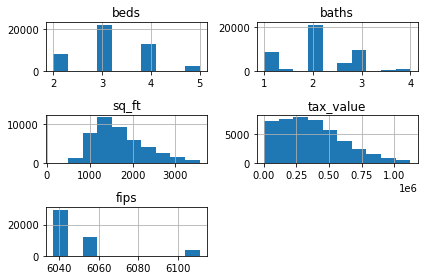

In [20]:
no_outliers.hist()
plt.tight_layout()

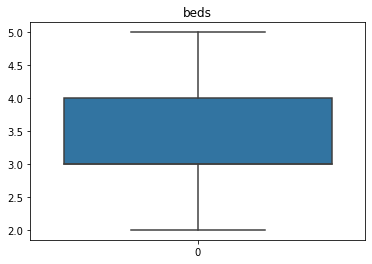

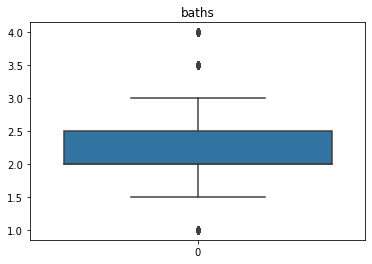

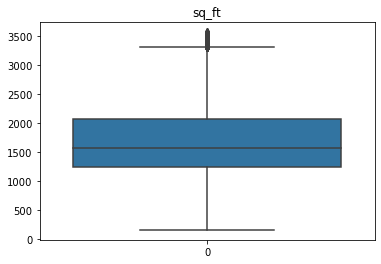

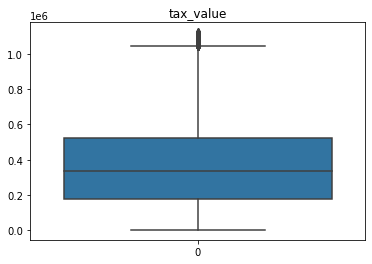

In [21]:
for col in no_outliers.drop(columns='fips').columns:
    sns.boxplot(data=no_outliers[col])
    plt.title(col)
    plt.show()

In [22]:
# view total null values in each column
no_outliers.isna().sum()

beds         0
baths        0
sq_ft        0
tax_value    0
fips         0
dtype: int64

Great! Distributions look more normal and remaining outliers are more manageable. Also, there are no missing values to worry about after removing the outliers!

Now I need to work on scaling the data. I will use the standard scaler because it will scale the values such that they are centered around a mean of 0. After splitting the data, I will fit the scaler object to train and transform it on train, validate, and test.

***Note: I do wonder if I should encode the `fips` column. After my MVP I want to go back and see if that makes my model better.***

Before I can do any scaling, I need to split the data into train, validate, and test samples. So that my data split can be reproduced, I am setting random_state=123 within the split function below.

In [23]:
# define split function
def split_data(df):
    '''
    This function takes in a dataframe and splits it into three dataframes.
    It returns these dataframes in this order: train, validate, test.
    Train makes up 56% of the total observations, validate 24%, and test 20%.
    '''
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train, test_size=0.3, random_state=123)
    return train, validate, test


In [24]:
# make sure split function works
train, validate, test = split_data(no_outliers)
train.shape, validate.shape, test.shape

((25550, 5), (10950, 5), (9126, 5))

In [25]:
# import scaler
from sklearn.preprocessing import StandardScaler
# create scaler object
scaler = StandardScaler()
# fit scaler to train only
scaler.fit(train.drop(columns='fips'))
# create new columns of scaled data
train[['beds_scaled', 'baths_scaled', 'sq_ft_scaled', 'tax_value_scaled']] = scaler.transform(train.drop(columns='fips'))
train.head()
# repeat for validate and test
validate[['beds_scaled', 'baths_scaled', 'sq_ft_scaled', 'tax_value_scaled']] = scaler.transform(validate.drop(columns='fips'))
test[['beds_scaled', 'baths_scaled', 'sq_ft_scaled', 'tax_value_scaled']] = scaler.transform(test.drop(columns='fips'))

<ipython-input-25-2154892d0d89>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['beds_scaled', 'baths_scaled', 'sq_ft_scaled', 'tax_value_scaled']] = scaler.transform(test.drop(columns='fips'))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


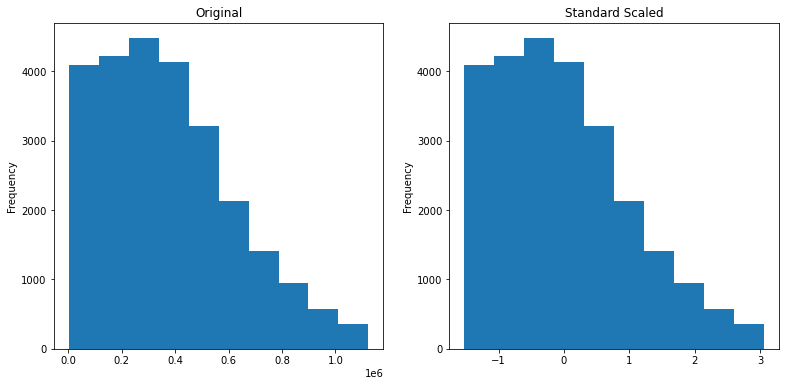

In [26]:
plt.figure(figsize=(13, 6))

# plot unscaled distribution
plt.subplot(121)
train.tax_value.plot.hist(title='Original')

# plot scaled distribution
plt.subplot(122)
train.tax_value_scaled.plot.hist(title='Standard Scaled');

In [27]:
def standard_scale_data(train, validate, test, cols):
    '''
    This function takes in train, validate, and test samples of the zillow data and 
    a list of columns to be scaled. It returns those dataframes with columns of 
    standard-scaled data added.
    '''
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train[scaled_cols])
    train[[f'{col}_scaled' for col in scaled_cols]] = scaler.transform(train[scaled_cols])
    validate[[f'{col}_scaled' for col in scaled_cols]] = scaler.transform(validate[scaled_cols])
    test[[f'{col}_scaled' for col in scaled_cols]] = scaler.transform(test[scaled_cols])
    return train, validate, test

In [28]:
# test function
train, validate, test = split_data(remove_outliers(acquire_zillow(), ['beds', 'baths', 'sq_ft', 'tax_value'], 1.5))

scaled_cols = train.drop(columns=['fips', 'tax_value']).columns

train, validate, test = standard_scale_data(train, validate, test, scaled_cols)
train.head()


,beds,baths,sq_ft,tax_value,fips,beds_scaled,baths_scaled,sq_ft_scaled
17227,2.0,1.0,877.0,148732.0,6037.0,-1.536937,-1.517808,-1.348418
36170,3.0,2.0,1386.0,319465.0,6059.0,-0.268813,-0.139870,-0.518473
16538,4.0,2.5,2064.0,810703.0,6059.0,0.999311,0.549099,0.587033
29765,3.0,2.0,1323.0,393000.0,6037.0,-0.268813,-0.139870,-0.621197
22836,4.0,3.0,2605.0,202872.0,6037.0,0.999311,1.238067,1.469155


In [29]:
# combine all functions into one
def wrangle_zillow(out_cols, k, scaled_cols):
    '''
    This function takes in a list of columns from which to remove outliers, a k-value 
    that determines cutoff points for outlier removal, and a list of columns to be scaled.
    It returns three dataframes (train, validate, and test) derived from the zillow data 
    after outliers were removed and columns of scaled data were added.
    '''
    train, validate, test = split_data(remove_outliers(acquire_zillow(), out_cols, k))
    train, validate, test = standard_scale_data(train, validate, test, scaled_cols)
    return train, validate, test

In [30]:
# test function
out_cols = ['beds', 'baths', 'sq_ft', 'tax_value']
scaled_cols = ['beds', 'baths', 'sq_ft']
wrangle_zillow(out_cols, 1.5, scaled_cols)
train.head()


,beds,baths,sq_ft,tax_value,fips,beds_scaled,baths_scaled,sq_ft_scaled
17227,2.0,1.0,877.0,148732.0,6037.0,-1.536937,-1.517808,-1.348418
36170,3.0,2.0,1386.0,319465.0,6059.0,-0.268813,-0.139870,-0.518473
16538,4.0,2.5,2064.0,810703.0,6059.0,0.999311,0.549099,0.587033
29765,3.0,2.0,1323.0,393000.0,6037.0,-0.268813,-0.139870,-0.621197
22836,4.0,3.0,2605.0,202872.0,6037.0,0.999311,1.238067,1.469155


Now that I have my data wrangled for my MVP, I will move onto Exploration and if I have time, I will come back to this stage to encode `fips` and also add in a column of the corresponding locations of `fips` values.